# Group Dynamics

This document takes a look at group dynamics.

## Setup

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import tensorflow as tf
from tensorflow.keras.models import load_model
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from src.face_utils import detect_faces, detect_faces2, visualize_face_detection
from src.gaze_utils import analyze_gaze, analyze_group_gaze
from src.proximity_utils import calculate_face_centers, normalize_proximity_matrix, calculate_proximity_matrix

Loaded emotion model from models/emotion_recognition_transfer_precision.h5


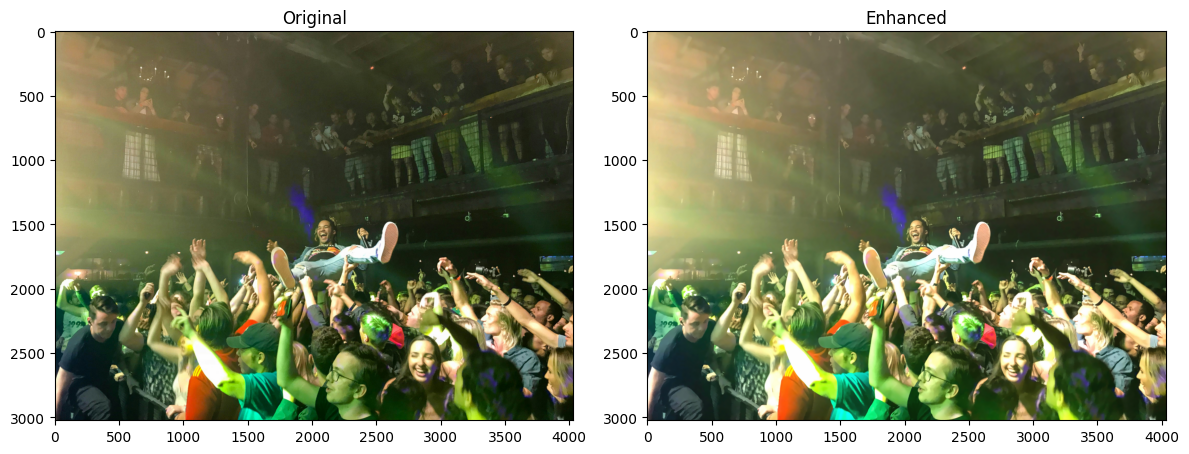

Running MediaPipe detection...
Running Haar Cascade detection...
Filtered Haar detections from 46 to 8
Running face_recognition detection...

Detections by method (before NMS):
  MediaPipe-1: 2 faces
  Haar-1.2: 4 faces
  Haar-1.1: 4 faces
  face_recognition: 4 faces
  Total: 14 faces

Detected 5 faces after NMS filtering

Detections by method (after NMS):
  Haar-1.2: 2 faces
  MediaPipe-1: 2 faces
  face_recognition: 1 faces


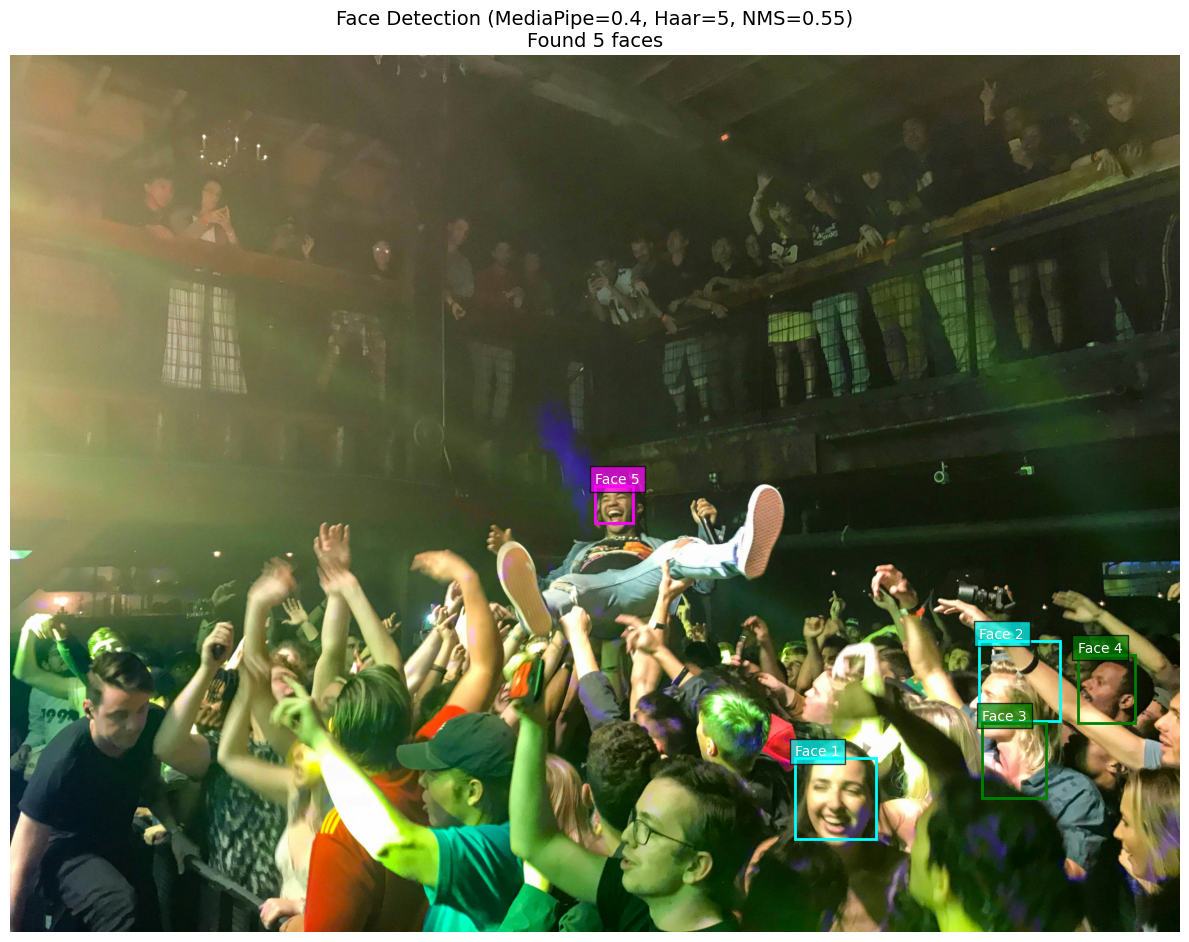

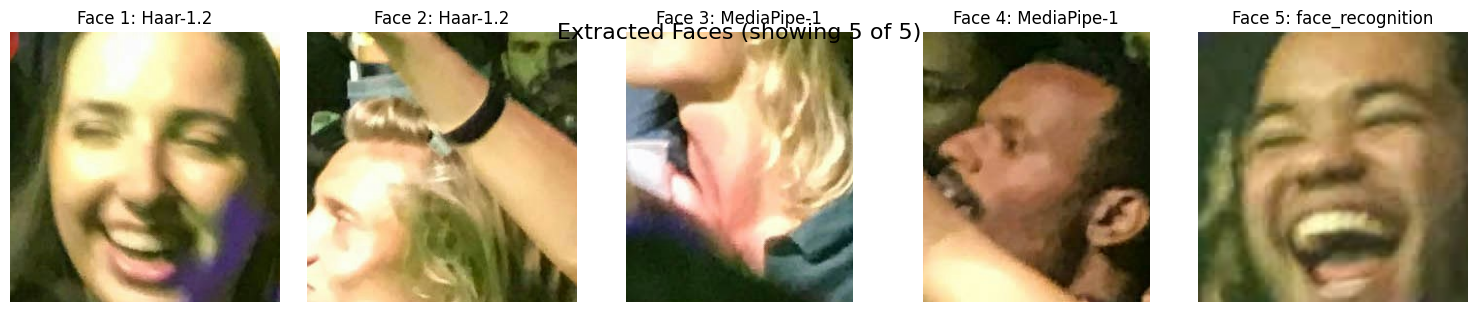

Using detection parameters:
  - MediaPipe confidence: 0.40
  - Haar min neighbors: 4
  - NMS threshold: 0.55
  - Filter Haar: True
  - Max Haar detections: 10
Running MediaPipe detection...
Running Haar Cascade detection...
Running face_recognition detection...
Detected 6 faces after NMS filtering


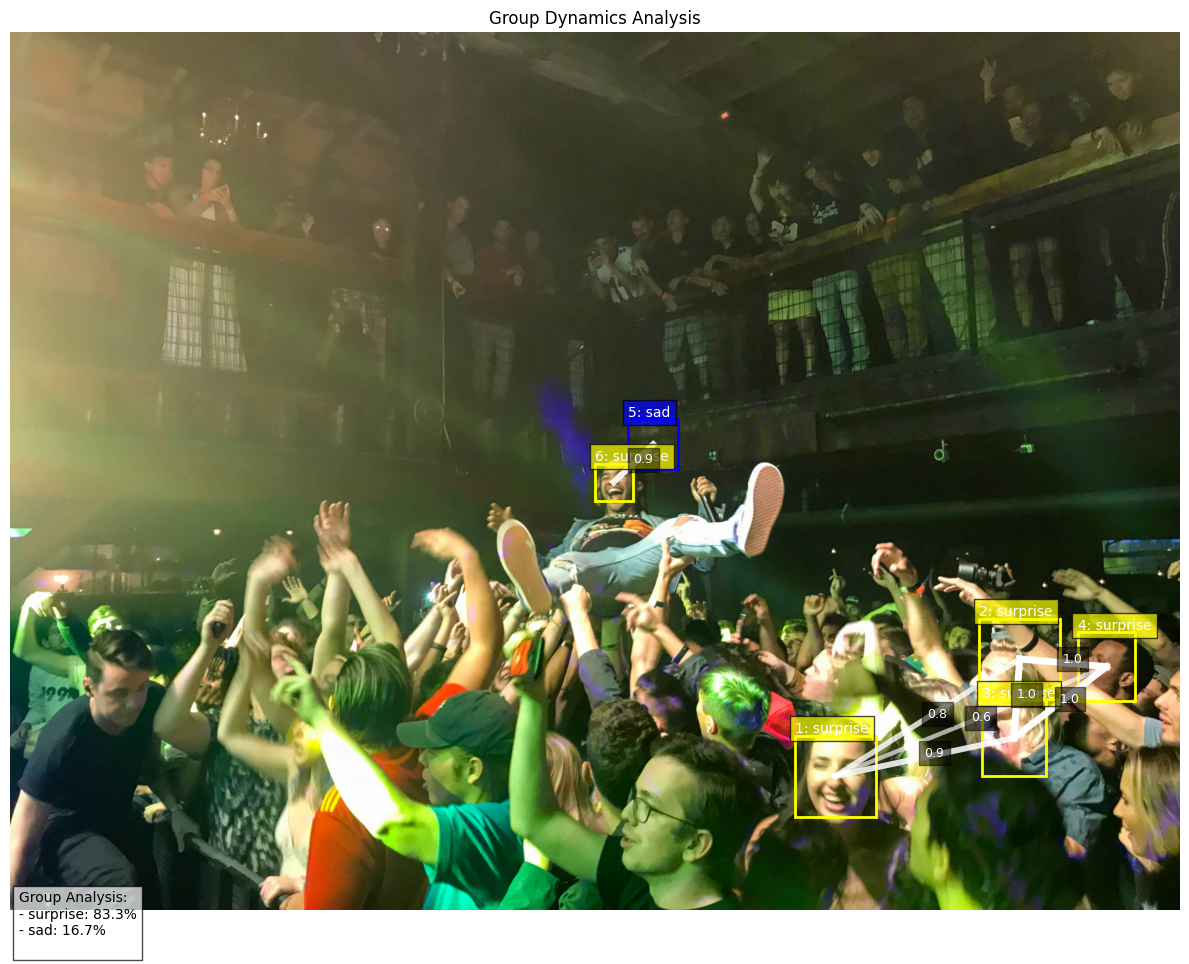

Group Dynamics Analysis Results:
- Detected 6 people in the image
- Group emotions:
  * surprise: 83.3%
  * sad: 16.7%
- Strong relationships detected:
  * Person 2 and Person 3: 1.00
  * Person 2 and Person 4: 1.00
  * Person 3 and Person 4: 0.98
  * Person 5 and Person 6: 0.90
  * Person 1 and Person 3: 0.85
  * Person 1 and Person 2: 0.78


In [8]:
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Function to load the emotion detection model
def load_emotion_model(model_path='models/emotion_recognition_transfer_precision.h5'):
    """Load the pre-trained emotion recognition model"""
    try:
        model = load_model(model_path)
        print(f"Loaded emotion model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading emotion model: {e}")
        print("Will use random emotions as fallback")
        return None

# Load the model once
emotion_model = load_emotion_model()

# Function to preprocess a face for emotion detection
def preprocess_face_for_emotion(face_img, target_size=(224, 224)):
    """Preprocess a face image for emotion detection with MobileNetV2"""
    try:
        # Make sure the image is RGB (3 channels)
        if len(face_img.shape) == 2:  # If grayscale
            face_img = cv2.cvtColor(face_img, cv2.COLOR_GRAY2RGB)
        elif face_img.shape[2] == 1:  # If grayscale with channel dimension
            face_img = cv2.cvtColor(face_img, cv2.COLOR_GRAY2RGB)
        elif face_img.shape[2] == 3:  # If already RGB
            pass
        else:
            print(f"Unexpected image shape: {face_img.shape}")
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        face_img = cv2.resize(face_img, target_size)
        
        # Normalize pixel values (MobileNetV2 preprocessing)
        face_img = face_img / 127.5 - 1.0
        
        # Reshape for model input [batch_size, height, width, channels]
        face_img = np.expand_dims(face_img, 0)
        
        return face_img
    except Exception as e:
        print(f"Error preprocessing face: {e}")
        # Return a blank, properly shaped input as fallback
        return np.zeros((1, target_size[0], target_size[1], 3))

# Update the detect_emotion function to use the model
def detect_emotion(face_image):
    """Detect emotion in a face image using the pre-trained model"""
    global emotion_model
    
    if emotion_model is None:
        # Fallback to random emotions if model couldn't be loaded
        emotions = ['happy', 'sad', 'neutral', 'surprise', 'angry']
        weights = [0.5, 0.1, 0.2, 0.1, 0.1]  # Make happy more likely for demo
        return np.random.choice(emotions, p=weights)
    
    try:
        # Preprocess the face for MobileNetV2 (224x224 RGB)
        processed_face = preprocess_face_for_emotion(face_image)
        
        # Get prediction
        prediction = emotion_model.predict(processed_face, verbose=0)[0]
        
        # Return the emotion with highest probability
        emotion_idx = np.argmax(prediction)
        return EMOTIONS[emotion_idx]
    except Exception as e:
        print(f"Error in emotion detection: {e}")
        return 'neutral'  # Default fallback

def analyze_group_relationships(emotions, proximity_matrix, gaze_targets):
    """Analyze relationships between individuals in the group"""
    num_people = len(emotions)
    relationships = np.zeros((num_people, num_people))
    
    for i in range(num_people):
        for j in range(num_people):
            if i == j:
                continue
                
            # Start with base proximity score
            relationship_score = proximity_matrix[i, j]
            
            # Boost if i is looking at j
            if gaze_targets[i] == j:
                relationship_score += 0.3
                
            # Boost if both people have same emotion
            if emotions[i] == emotions[j]:
                relationship_score += 0.2
                
            # Boost if both looking at each other
            if gaze_targets[i] == j and gaze_targets[j] == i:
                relationship_score += 0.4
                
            relationships[i, j] = min(relationship_score, 1.0)  # Cap at 1.0
    
    return relationships

def analyze_group_dynamics(image_path):
    """Analyze group dynamics in an image"""
    # Detect faces
    faces, boxes, image = detect_faces2(image_path)
    
    if len(faces) < 2:
        print("Need at least 2 faces to analyze group dynamics!")
        return None
    
    # Calculate centers
    centers = calculate_face_centers(boxes)
    
    # Analyze emotions
    emotions = [detect_emotion(face) for face in faces]
    
    # Analyze gaze - with error handling
    gaze_results = []
    for face in faces:
        try:
            # Make sure we're using the correct format for face_bbox
            face_bbox = [0, 0, face.shape[1], face.shape[0]]
            result = analyze_gaze(face, face_bbox)
            gaze_results.append(result)
        except Exception as e:
            print(f"Error analyzing gaze: {e}")
            gaze_results.append({'success': False, 'direction': 'unknown', 'left_gaze_ratio': 0, 'right_gaze_ratio': 0, 'avg_gaze_ratio': 0})
    
    # Convert scalar gaze ratios to vectors for visualization
    gaze_vectors = []
    for result in gaze_results:
        if result['success']:
            # Create a proper gaze vector [x, y] for visualization
            # Convert from ratio to -1 to 1 range (1.0 is center)
            x_direction = result['avg_gaze_ratio'] - 1.0  # negative = left, positive = right
            gaze_vectors.append([x_direction, 0])  # only using horizontal direction
        else:
            gaze_vectors.append([0, 0])  # neutral gaze
    
    # Calculate proximity
    proximity_matrix = calculate_proximity_matrix(centers)
    normalized_proximity = normalize_proximity_matrix(proximity_matrix)
    
    # Fix analyze_group_gaze call - it seems to expect different parameters
    # Looking at your code, it's likely supposed to determine gaze targets based on 
    # face positions and gaze directions
    try:
        # Use face indices as default targets
        gaze_targets = [-1] * len(faces)  # Default: no targets
        
        # Try to find targets based on gaze directions
        for i, gaze_vector in enumerate(gaze_vectors):
            if abs(gaze_vector[0]) > 0.3:  # Only consider strong gazes
                x_dir = gaze_vector[0]
                potential_targets = []
                
                for j, other_center in enumerate(centers):
                    if i != j:  # Don't consider self
                        dx = other_center[0] - centers[i][0]
                        # Only consider targets in the direction of gaze
                        if (x_dir < 0 and dx < 0) or (x_dir > 0 and dx > 0):
                            potential_targets.append((j, abs(dx)))
                
                if potential_targets:
                    # Choose the closest target in the gaze direction
                    target, _ = min(potential_targets, key=lambda x: x[1])
                    gaze_targets[i] = target
    except Exception as e:
        print(f"Error determining gaze targets: {e}")
        gaze_targets = [-1] * len(faces)
    
    # Analyze relationships
    relationship_matrix = analyze_group_relationships(emotions, normalized_proximity, gaze_targets)
    
    # Prepare results dictionary
    results = {
        'image': image,
        'faces': faces,
        'boxes': boxes,
        'centers': centers,
        'emotions': emotions,
        'gaze_vectors': gaze_vectors,
        'proximity_matrix': normalized_proximity,
        'gaze_targets': gaze_targets,
        'relationship_matrix': relationship_matrix
    }
    
    return results

def visualize_group_dynamics(results):
    """Visualize group dynamics analysis results"""
    if results is None:
        return
        
    image = results['image']
    boxes = results['boxes']
    centers = results['centers']
    emotions = results['emotions']
    gaze_vectors = results['gaze_vectors']
    gaze_targets = results['gaze_targets']
    relationship_matrix = results['relationship_matrix']
    
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    
    # Define emotion colors
    emotion_colors = {
        'happy': 'green',
        'sad': 'blue',
        'neutral': 'gray',
        'surprised': 'purple',
        'angry': 'red'
    }
    
    # Draw boxes and emotion labels
    for i, (box, emotion) in enumerate(zip(boxes, emotions)):
        x1, y1, x2, y2 = box
        color = emotion_colors.get(emotion, 'yellow')
        
        # Draw box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color=color, linewidth=2)
        plt.gca().add_patch(rect)
        
        # Show emotion label
        plt.text(x1, y1-10, f"{i+1}: {emotion}", color='white', fontsize=10,
                 bbox=dict(facecolor=color, alpha=0.7))
    
    # Draw gaze directions
    for i, (center, gaze_vector) in enumerate(zip(centers, gaze_vectors)):
        # Skip if gaze is neutral
        if abs(gaze_vector[0]) < 0.2:
            continue
            
        # Draw gaze arrow
        dx = gaze_vector[0] * 100  # Scale for visibility
        dy = 0  # We're only using horizontal gaze for simplicity
        
        plt.arrow(center[0], center[1], dx, dy, 
                 head_width=15, head_length=15, fc='cyan', ec='cyan', alpha=0.7)
    
    # Draw relationship lines
    for i in range(len(boxes)):
        for j in range(i+1, len(boxes)):
            relationship_strength = relationship_matrix[i, j]
            
            # Only draw strong relationships
            if relationship_strength > 0.6:
                plt.plot([centers[i][0], centers[j][0]], 
                         [centers[i][1], centers[j][1]], 
                         'w-', alpha=relationship_strength, 
                         linewidth=relationship_strength*5)
                
                # Show relationship strength
                mid_x = (centers[i][0] + centers[j][0]) // 2
                mid_y = (centers[i][1] + centers[j][1]) // 2
                plt.text(mid_x, mid_y, f"{relationship_strength:.1f}", 
                         color='white', fontsize=9,
                         bbox=dict(facecolor='black', alpha=0.5))
    
    # Add summary text
    group_emotions = {}
    for emotion in emotions:
        group_emotions[emotion] = group_emotions.get(emotion, 0) + 1
    
    summary_text = "Group Analysis:\n"
    for emotion, count in group_emotions.items():
        percentage = count / len(emotions) * 100
        summary_text += f"- {emotion}: {percentage:.1f}%\n"
    
    plt.figtext(0.02, 0.02, summary_text, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title("Group Dynamics Analysis")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Test on an image if available
def test_group_dynamics(image_path):
    """Test group dynamics analysis on an image"""
    results = analyze_group_dynamics(image_path)
    if results:
        visualize_group_dynamics(results)
        
        # Print insights
        print("Group Dynamics Analysis Results:")
        print(f"- Detected {len(results['faces'])} people in the image")
        
        # Count emotions
        emotion_counts = {}
        for emotion in results['emotions']:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        
        print("- Group emotions:")
        for emotion, count in emotion_counts.items():
            percentage = count / len(results['emotions']) * 100
            print(f"  * {emotion}: {percentage:.1f}%")
        
        # Find strongest relationships
        relationships = results['relationship_matrix']
        strongest = []
        
        for i in range(len(relationships)):
            for j in range(i+1, len(relationships)):
                if relationships[i, j] > 0.7:
                    strongest.append((i, j, relationships[i, j]))
        
        if strongest:
            print("- Strong relationships detected:")
            for i, j, strength in sorted(strongest, key=lambda x: x[2], reverse=True):
                print(f"  * Person {i+1} and Person {j+1}: {strength:.2f}")

# Test on an image if available
if os.path.exists('../data2/test_images'):
    test_files = os.listdir('../data2/test_images')
    if len(test_files) > 0:
        test_image = os.path.join('../data2/test_images', test_files[0])
        visualize_face_detection(test_image)
        test_group_dynamics(test_image)
    else:
        print("No test images found!")
else:
    print("Test images folder not found!")

## Creating .py file

In [29]:
# Create the src directory if it doesn't exist
import os
os.makedirs('src', exist_ok=True)

# Write the group_analysis.py file
with open('src/group_analysis.py', 'w') as f:
    f.write("""import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from src.face_utils import detect_faces
from src.proximity_utils import calculate_face_centers, calculate_proximity_matrix, normalize_proximity_matrix
from src.gaze_utils import analyze_gaze

# Define emotions for the model
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Load the emotion detection model
def load_emotion_model(model_path='models/emotion_recognition_transfer_precision.h5'):
    \"\"\"Load the pre-trained emotion recognition model\"\"\"
    try:
        model = load_model(model_path)
        print(f"Loaded emotion model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading emotion model: {e}")
        print("Will use random emotions as fallback")
        return None

# Global model variable
emotion_model = load_emotion_model()

def preprocess_face_for_emotion(face_img, target_size=(224, 224)):
    \"\"\"Preprocess a face image for emotion detection with MobileNetV2\"\"\"
    try:
        # Make sure the image is RGB (3 channels)
        if len(face_img.shape) == 2:  # If grayscale
            face_img = cv2.cvtColor(face_img, cv2.COLOR_GRAY2RGB)
        elif face_img.shape[2] == 1:  # If grayscale with channel dimension
            face_img = cv2.cvtColor(face_img, cv2.COLOR_GRAY2RGB)
        elif face_img.shape[2] == 3:  # If already RGB
            pass
        else:
            print(f"Unexpected image shape: {face_img.shape}")
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        face_img = cv2.resize(face_img, target_size)
        
        # Normalize pixel values (MobileNetV2 preprocessing)
        face_img = face_img / 127.5 - 1.0
        
        # Reshape for model input [batch_size, height, width, channels]
        face_img = np.expand_dims(face_img, 0)
        
        return face_img
    except Exception as e:
        print(f"Error preprocessing face: {e}")
        # Return a blank, properly shaped input as fallback
        return np.zeros((1, target_size[0], target_size[1], 3))

def detect_emotion(face_image):
    \"\"\"Detect emotion in a face image using the pre-trained model\"\"\"
    global emotion_model
    
    if emotion_model is None:
        # Fallback to random emotions if model couldn't be loaded
        emotions = ['happy', 'sad', 'neutral', 'surprise', 'angry']
        weights = [0.5, 0.1, 0.2, 0.1, 0.1]  # Make happy more likely for demo
        return np.random.choice(emotions, p=weights)
    
    try:
        # Preprocess the face for MobileNetV2 (224x224 RGB)
        processed_face = preprocess_face_for_emotion(face_image)
        
        # Get prediction
        prediction = emotion_model.predict(processed_face, verbose=0)[0]
        
        # Return the emotion with highest probability
        emotion_idx = np.argmax(prediction)
        return EMOTIONS[emotion_idx]
    except Exception as e:
        print(f"Error in emotion detection: {e}")
        return 'neutral'  # Default fallback

def analyze_group_relationships(emotions, proximity_matrix, gaze_targets):
    \"\"\"Analyze relationships between individuals in the group\"\"\"
    num_people = len(emotions)
    relationships = np.zeros((num_people, num_people))
    
    for i in range(num_people):
        for j in range(num_people):
            if i == j:
                continue
                
            # Start with base proximity score
            relationship_score = proximity_matrix[i, j]
            
            # Boost if i is looking at j
            if gaze_targets[i] == j:
                relationship_score += 0.3
                
            # Boost if both people have same emotion
            if emotions[i] == emotions[j]:
                relationship_score += 0.2
                
            # Boost if both looking at each other
            if gaze_targets[i] == j and gaze_targets[j] == i:
                relationship_score += 0.4
                
            relationships[i, j] = min(relationship_score, 1.0)  # Cap at 1.0
    
    return relationships

def analyze_group_dynamics(image_path):
    \"\"\"Analyze group dynamics in an image\"\"\"
    # Detect faces
    faces, boxes, image = detect_faces(image_path)
    
    if len(faces) < 2:
        print("Need at least 2 faces to analyze group dynamics!")
        return None
    
    # Calculate centers
    centers = calculate_face_centers(boxes)
    
    # Analyze emotions using the trained model
    emotions = [detect_emotion(face) for face in faces]
    
    # Analyze gaze - with error handling
    gaze_results = []
    for face in faces:
        try:
            # Make sure we're using the correct format for face_bbox
            face_bbox = [0, 0, face.shape[1], face.shape[0]]
            result = analyze_gaze(face, face_bbox)
            gaze_results.append(result)
        except Exception as e:
            print(f"Error analyzing gaze: {e}")
            gaze_results.append({'success': False, 'direction': 'unknown', 'left_gaze_ratio': 0, 'right_gaze_ratio': 0, 'avg_gaze_ratio': 0})
    
    # Convert scalar gaze ratios to vectors for visualization
    gaze_vectors = []
    for result in gaze_results:
        if result['success']:
            # Create a proper gaze vector [x, y] for visualization
            # Convert from ratio to -1 to 1 range (1.0 is center)
            x_direction = result['avg_gaze_ratio'] - 1.0  # negative = left, positive = right
            gaze_vectors.append([x_direction, 0])  # only using horizontal direction
        else:
            gaze_vectors.append([0, 0])  # neutral gaze
    
    # Calculate proximity
    proximity_matrix = calculate_proximity_matrix(centers)
    normalized_proximity = normalize_proximity_matrix(proximity_matrix)
    
    # Determine gaze targets
    try:
        # Use face indices as default targets
        gaze_targets = [-1] * len(faces)  # Default: no targets
        
        # Try to find targets based on gaze directions
        for i, gaze_vector in enumerate(gaze_vectors):
            if abs(gaze_vector[0]) > 0.3:  # Only consider strong gazes
                x_dir = gaze_vector[0]
                potential_targets = []
                
                for j, other_center in enumerate(centers):
                    if i != j:  # Don't consider self
                        dx = other_center[0] - centers[i][0]
                        # Only consider targets in the direction of gaze
                        if (x_dir < 0 and dx < 0) or (x_dir > 0 and dx > 0):
                            potential_targets.append((j, abs(dx)))
                
                if potential_targets:
                    # Choose the closest target in the gaze direction
                    target, _ = min(potential_targets, key=lambda x: x[1])
                    gaze_targets[i] = target
    except Exception as e:
        print(f"Error determining gaze targets: {e}")
        gaze_targets = [-1] * len(faces)
    
    # Analyze relationships
    relationship_matrix = analyze_group_relationships(emotions, normalized_proximity, gaze_targets)
    
    # Prepare results dictionary
    results = {
        'image': image,
        'faces': faces,
        'boxes': boxes,
        'centers': centers,
        'emotions': emotions,
        'gaze_vectors': gaze_vectors,
        'proximity_matrix': normalized_proximity,
        'gaze_targets': gaze_targets,
        'relationship_matrix': relationship_matrix
    }
    
    return results

def visualize_group_dynamics(results):
    \"\"\"Visualize group dynamics analysis results\"\"\"
    if results is None:
        return
        
    image = results['image']
    boxes = results['boxes']
    centers = results['centers']
    emotions = results['emotions']
    gaze_vectors = results['gaze_vectors']
    gaze_targets = results['gaze_targets']
    relationship_matrix = results['relationship_matrix']
    
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    
    # Define emotion colors
    emotion_colors = {
        'happy': 'green',
        'sad': 'blue',
        'neutral': 'gray',
        'surprise': 'purple',
        'angry': 'red',
        'disgust': 'brown',
        'fear': 'orange'
    }
    
    # Draw boxes and emotion labels
    for i, (box, emotion) in enumerate(zip(boxes, emotions)):
        x1, y1, x2, y2 = box
        color = emotion_colors.get(emotion, 'yellow')
        
        # Draw box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color=color, linewidth=2)
        plt.gca().add_patch(rect)
        
        # Show emotion label
        plt.text(x1, y1-10, f"{i+1}: {emotion}", color='white', fontsize=10,
                 bbox=dict(facecolor=color, alpha=0.7))
    
    # Draw gaze directions
    for i, (center, gaze_vector) in enumerate(zip(centers, gaze_vectors)):
        # Skip if gaze is neutral
        if abs(gaze_vector[0]) < 0.2:
            continue
            
        # Draw gaze arrow
        dx = gaze_vector[0] * 100  # Scale for visibility
        dy = 0  # We're only using horizontal gaze for simplicity
        
        plt.arrow(center[0], center[1], dx, dy, 
                 head_width=15, head_length=15, fc='cyan', ec='cyan', alpha=0.7)
    
    # Draw relationship lines
    for i in range(len(boxes)):
        for j in range(i+1, len(boxes)):
            relationship_strength = relationship_matrix[i, j]
            
            # Only draw strong relationships
            if relationship_strength > 0.6:
                plt.plot([centers[i][0], centers[j][0]], 
                         [centers[i][1], centers[j][1]], 
                         'w-', alpha=relationship_strength, 
                         linewidth=relationship_strength*5)
                
                # Show relationship strength
                mid_x = (centers[i][0] + centers[j][0]) // 2
                mid_y = (centers[i][1] + centers[j][1]) // 2
                plt.text(mid_x, mid_y, f"{relationship_strength:.1f}", 
                         color='white', fontsize=9,
                         bbox=dict(facecolor='black', alpha=0.5))
    
    # Add summary text
    group_emotions = {}
    for emotion in emotions:
        group_emotions[emotion] = group_emotions.get(emotion, 0) + 1
    
    summary_text = "Group Analysis:\\n"
    for emotion, count in group_emotions.items():
        percentage = count / len(emotions) * 100
        summary_text += f"- {emotion}: {percentage:.1f}%\\n"
    
    plt.figtext(0.02, 0.02, summary_text, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title("Group Dynamics Analysis")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def test_group_dynamics(image_path):
    \"\"\"Test group dynamics analysis on an image\"\"\"
    results = analyze_group_dynamics(image_path)
    if results:
        visualize_group_dynamics(results)
        
        # Print insights
        print("Group Dynamics Analysis Results:")
        print(f"- Detected {len(results['faces'])} people in the image")
        
        # Count emotions
        emotion_counts = {}
        for emotion in results['emotions']:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        
        print("- Group emotions:")
        for emotion, count in emotion_counts.items():
            percentage = count / len(results['emotions']) * 100
            print(f"  * {emotion}: {percentage:.1f}%")
        
        # Find strongest relationships
        relationships = results['relationship_matrix']
        strongest = []
        
        for i in range(len(relationships)):
            for j in range(i+1, len(relationships)):
                if relationships[i, j] > 0.7:
                    strongest.append((i, j, relationships[i, j]))
        
        if strongest:
            print("- Strong relationships detected:")
            for i, j, strength in sorted(strongest, key=lambda x: x[2], reverse=True):
                print(f"  * Person {i+1} and Person {j+1}: {strength:.2f}")
""")

print("Group analysis functions saved to src/group_analysis.py")

Group analysis functions saved to src/group_analysis.py
